In [43]:
import pandas as pd
import numpy as np
import mlflow
import mlflow.sklearn
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor



In [44]:
weather = pd.read_csv("london_weather.csv")


# converting the date format
weather["date"] = weather["date"].apply(lambda x:pd.to_datetime(str(x), format = '%Y%m%d'))

# taking the month
weather["month"] = weather["date"].dt.month
weather["year"] = weather["date"].dt.year
weather.head()

,date,cloud_cover,sunshine,global_radiation,max_temp,mean_temp,min_temp,precipitation,pressure,snow_depth,month,year
0,1979-01-01,2.0,7.0,52.0,2.3,-4.1,-7.5,0.4,101900.0,9.0,1,1979
1,1979-01-02,6.0,1.7,27.0,1.6,-2.6,-7.5,0.0,102530.0,8.0,1,1979
2,1979-01-03,5.0,0.0,13.0,1.3,-2.8,-7.2,0.0,102050.0,4.0,1,1979
3,1979-01-04,8.0,0.0,13.0,-0.3,-2.6,-6.5,0.0,100840.0,2.0,1,1979
4,1979-01-05,6.0,2.0,29.0,5.6,-0.8,-1.4,0.0,102250.0,1.0,1,1979


In [45]:
print(weather.head())
print(weather.describe())

        date  cloud_cover  sunshine  global_radiation  max_temp  mean_temp  \
0 1979-01-01          2.0       7.0              52.0       2.3       -4.1   
1 1979-01-02          6.0       1.7              27.0       1.6       -2.6   
2 1979-01-03          5.0       0.0              13.0       1.3       -2.8   
3 1979-01-04          8.0       0.0              13.0      -0.3       -2.6   
4 1979-01-05          6.0       2.0              29.0       5.6       -0.8   

   min_temp  precipitation  pressure  snow_depth  month  year  
0      -7.5            0.4  101900.0         9.0      1  1979  
1      -7.5            0.0  102530.0         8.0      1  1979  
2      -7.2            0.0  102050.0         4.0      1  1979  
3      -6.5            0.0  100840.0         2.0      1  1979  
4      -1.4            0.0  102250.0         1.0      1  1979  
                      date   cloud_cover      sunshine  global_radiation  \
count                15341  15322.000000  15341.000000      15322.00000

In [46]:
weather[["mean_temp","month"]].groupby(["month"]).mean()

,mean_temp
month,
1,5.162462
2,5.398986
3,7.606091
4,10.097615
5,13.398921
6,16.459459
7,18.795158
8,18.451424
9,15.735959


<Axes: xlabel='month', ylabel='mean_temp'>

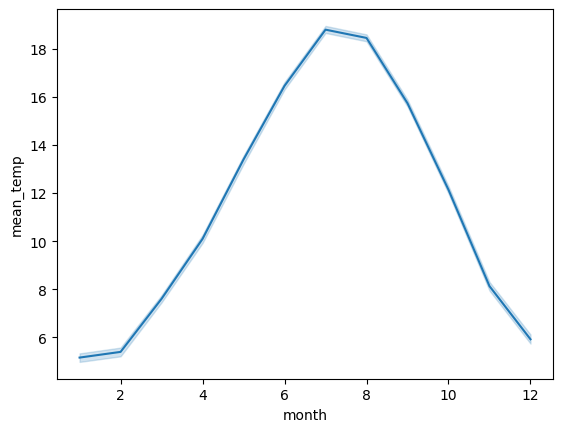

In [47]:
sns.lineplot(data=weather, x="month", y="mean_temp")

<Axes: xlabel='year', ylabel='mean_temp'>

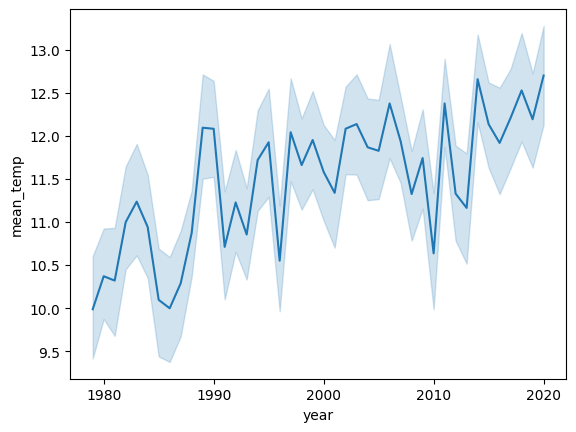

In [48]:
sns.lineplot(data=weather, x="year", y="mean_temp")

[Text(0.5, 1.0, 'Correlation between variables')]

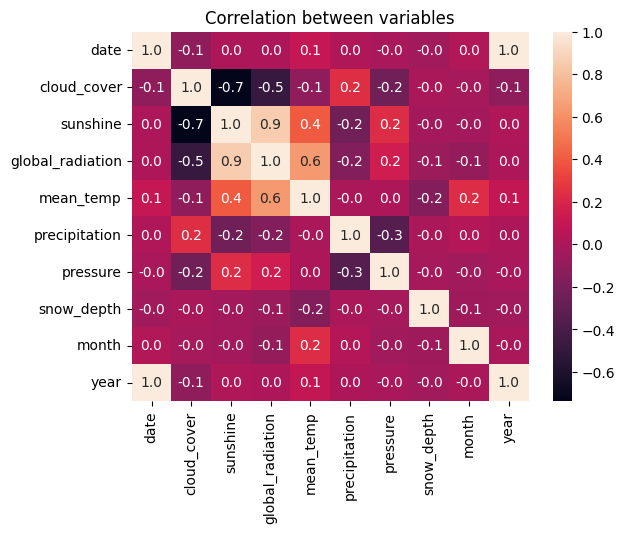

In [49]:
weather_corr = weather.drop(["max_temp","min_temp"], axis=1).corr()
sns.heatmap(weather_corr, annot=True, fmt=".1f").set(title="Correlation between variables")


In [50]:
feature_selection = ["global_radiation","sunshine","month","cloud_cover","precipitation","pressure"]
weather = weather.dropna(subset=['mean_temp'])
X = weather[feature_selection]
y = weather[["mean_temp"]]
# X.head()

# split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=1)

# Impute misising value
imputer = SimpleImputer(strategy="mean")
# Fit on the training data
X_train = imputer.fit_transform(X_train)
# Transform on the test data
X_test = imputer.transform(X_test)


# Scale the data
scaler = StandardScaler()
# Fit on the training data
X_train = scaler.fit_transform(X_train)
# Transform on the test data
X_test = scaler.transform(X_test)


In [51]:
# Predict, evaluate, and log the parameters and metrics of your models
for idx, depth in enumerate ([1, 5]):
    run_name = f"run_{idx}"
    print(run_name)
    with mlflow.start_run(run_name = run_name):

        #Create models
        lin_reg = LinearRegression().fit(X_train, y_train)
        tree_reg = DecisionTreeRegressor(random_state=42, max_depth=depth).fit(X_train, y_train)
        forest_reg = RandomForestRegressor(random_state=42, max_depth=depth).fit(X_train, y_train)
        
        #Log models
        mlflow.sklearn.log_model(lin_reg, "lin_reg")
        mlflow.sklearn.log_model(tree_reg, "tree_reg")
        mlflow.sklearn.log_model(forest_reg, "forest_reg")
    
        #Evaluate performance
        y_pred_lin_reg = lin_reg.predict(X_test)
        lin_reg_rmse = mean_squared_error(y_test, y_pred_lin_reg, squared = False)
        
        y_pred_tree_reg = tree_reg.predict(X_test)
        tree_reg_rmse = mean_squared_error(y_test, y_pred_tree_reg, squared = False)
        
        y_pred_forest_reg = forest_reg.predict(X_test)
        forest_reg_rmse = mean_squared_error(y_test, y_pred_forest_reg, squared=False)
        
        #Log performance
        mlflow.log_param("max_depth", depth)
        mlflow.log_metric("rmse_LR", lin_reg_rmse)
        mlflow.log_metric("rmse_TR", tree_reg_rmse)
        mlflow.log_metric("rmse_RF", forest_reg_rmse)
              
  
        
#Search the runs for the experiment's results
experiment_results = mlflow.search_runs()
experiment_results

run_0


/Users/studytube/OTHER_DOCUMENTS/STUDY/GITHUB_REPOS/datacamp-london-tempereature-prediction/.venv/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/studytube/OTHER_DOCUMENTS/STUDY/GITHUB_REPOS/datacamp-london-tempereature-prediction/.venv/lib/python3.11/site-packages/_distutils_hack/__init__.py:18: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(
/Users/studytube/OTHER_DOCUMENTS/STUDY/GITHUB_REPOS/datacamp-london-tem

run_1


/Users/studytube/OTHER_DOCUMENTS/STUDY/GITHUB_REPOS/datacamp-london-tempereature-prediction/.venv/lib/python3.11/site-packages/_distutils_hack/__init__.py:18: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(
/Users/studytube/OTHER_DOCUMENTS/STUDY/GITHUB_REPOS/datacamp-london-tempereature-prediction/.venv/lib/python3.11/site-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")
2024/08/24 18:11:48 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the

,run_id,experiment_id,status,artifact_uri,start_time,end_time,metrics.rmse_LR,metrics.rmse_TR,metrics.rmse_RF,params.max_depth,tags.mlflow.log-model.history,tags.mlflow.user,tags.mlflow.source.type,tags.mlflow.source.git.commit,tags.mlflow.runName,tags.mlflow.source.name
0,6a96b31ca80946cd8dea56f210569ebd,0,FINISHED,/Users/studytube/OTHER_DOCUMENTS/STUDY/GITHUB_...,2024-08-24 16:11:46.710000+00:00,2024-08-24 16:11:50.823000+00:00,3.866773,3.027733,2.967466,5,"[{""run_id"": ""6a96b31ca80946cd8dea56f210569ebd""...",studytube,LOCAL,d3cc63be73c9f03ccb7295c14c666d90cefd4b2c,run_1,/Users/studytube/OTHER_DOCUMENTS/STUDY/GITHUB_...
1,8e5ab83552ae4df5956c2a7673d4c7b1,0,FINISHED,/Users/studytube/OTHER_DOCUMENTS/STUDY/GITHUB_...,2024-08-24 16:11:42.409000+00:00,2024-08-24 16:11:46.692000+00:00,3.866773,4.752035,4.694655,1,"[{""run_id"": ""8e5ab83552ae4df5956c2a7673d4c7b1""...",studytube,LOCAL,d3cc63be73c9f03ccb7295c14c666d90cefd4b2c,run_0,/Users/studytube/OTHER_DOCUMENTS/STUDY/GITHUB_...
2,30066a773cba41f19b4a91ffe73efba6,0,FINISHED,/Users/studytube/OTHER_DOCUMENTS/STUDY/GITHUB_...,2024-08-24 16:10:54.331000+00:00,2024-08-24 16:10:59.780000+00:00,3.866773,3.792284,2.891106,20,"[{""run_id"": ""30066a773cba41f19b4a91ffe73efba6""...",studytube,LOCAL,d3cc63be73c9f03ccb7295c14c666d90cefd4b2c,run_3,/Users/studytube/OTHER_DOCUMENTS/STUDY/GITHUB_...
3,44524133f6ba48d18051c880dcfaac0c,0,FINISHED,/Users/studytube/OTHER_DOCUMENTS/STUDY/GITHUB_...,2024-08-24 16:10:49.720000+00:00,2024-08-24 16:10:54.330000+00:00,3.866773,3.073729,2.814127,10,"[{""run_id"": ""44524133f6ba48d18051c880dcfaac0c""...",studytube,LOCAL,d3cc63be73c9f03ccb7295c14c666d90cefd4b2c,run_2,/Users/studytube/OTHER_DOCUMENTS/STUDY/GITHUB_...
4,56843383ae85412eb3337cad546913eb,0,FINISHED,/Users/studytube/OTHER_DOCUMENTS/STUDY/GITHUB_...,2024-08-24 16:10:45.884000+00:00,2024-08-24 16:10:49.719000+00:00,3.866773,3.027733,2.967466,5,"[{""run_id"": ""56843383ae85412eb3337cad546913eb""...",studytube,LOCAL,d3cc63be73c9f03ccb7295c14c666d90cefd4b2c,run_1,/Users/studytube/OTHER_DOCUMENTS/STUDY/GITHUB_...
5,a7b92ced25b2418ca5cdc52d0fc989e2,0,FINISHED,/Users/studytube/OTHER_DOCUMENTS/STUDY/GITHUB_...,2024-08-24 16:10:41.917000+00:00,2024-08-24 16:10:45.883000+00:00,3.866773,4.752035,4.694655,1,"[{""run_id"": ""a7b92ced25b2418ca5cdc52d0fc989e2""...",studytube,LOCAL,d3cc63be73c9f03ccb7295c14c666d90cefd4b2c,run_0,/Users/studytube/OTHER_DOCUMENTS/STUDY/GITHUB_...


In [52]:
# ## This code is to delete the runs in the experiment

# run_ids = experiment_results["run_id"].to_list()
# for run_id in run_ids:
#     print(run_id)
    
#     # mlflow.delete_run(run_id)
# mlflow.delete_run('3ab2b070f1fd42358866babd5da9e193')
# experiment_results
# # m